## Filter compensation with the ripasso module

The broadbean module gets a helping hand from the ripasso module when it needs to compensate for transfer functions of transmission lines.

The ripasso module lets us apply filters and their inverses to signals.

The module has two built-in types of filter, namely an RC-circuit high-pass and an RC-circuit low-pass. The transfer functions are

$$
H_n(f)=\left(\frac{2\pi f\mathrm{i}\tau}{1+2\pi f\mathrm{i}\tau }\right)^{n},
$$
for the nth order high-pass and
$$
L_n(f)=\left(\frac{1}{1+2\pi f\mathrm{i}\tau }\right)^{n},
$$
for the nth order low-pass. The parameter $\tau$ is one over the cut-off frequency.

The inversion (filter compensation) is performed by mulitplying with the inverse transfer function in frequency space and transforming back to the time domain, e.g. for a given signal $s(t)$ and a high-pass filter of order n,

$$
    s_\text{filtered}(t) = \mathcal{F}^{-1}[\mathcal{F}[s](f)\cdot H_n(f)](t)
$$
and
$$
    s_\text{compensated}(t) = \mathcal{F}^{-1}[\mathcal{F}[s](f)\cdot H_{-n}(f)](t).
$$


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import sys
from broadbean.ripasso import applyRCFilter, applyInverseRCFilter, applyCustomTransferFunction

In [2]:
def squarewave(npts, periods=5):

    periods = int(periods)
    array = np.zeros(npts)

    for n in range(periods):
        array[int(n*npts/periods): int((2*n+1)*npts/2/periods)] = 1

    return array

## RC Filters

In [3]:
# Let's make some signals!

SR = int(10e3)
npts = int(10e3)

f_cut = 12  # filter cut-off frequency (Hz)

time = np.linspace(0, npts/SR, npts)
T = time[-1]

signal1 = np.sin(2*np.pi*5/T*time)+0.7*np.cos(2*np.pi*1/T*time)
signal2 = squarewave(npts, periods=4)

In [4]:
# Then we may high-pass them or low-pass them

filtertype = 'HP'
# filtertype = 'LP'

signal1_filt = applyRCFilter(signal1, SR, filtertype, f_cut, order=1)
signal2_filt = applyRCFilter(signal2, SR, filtertype, f_cut, order=1)

<IPython.core.display.Javascript object>


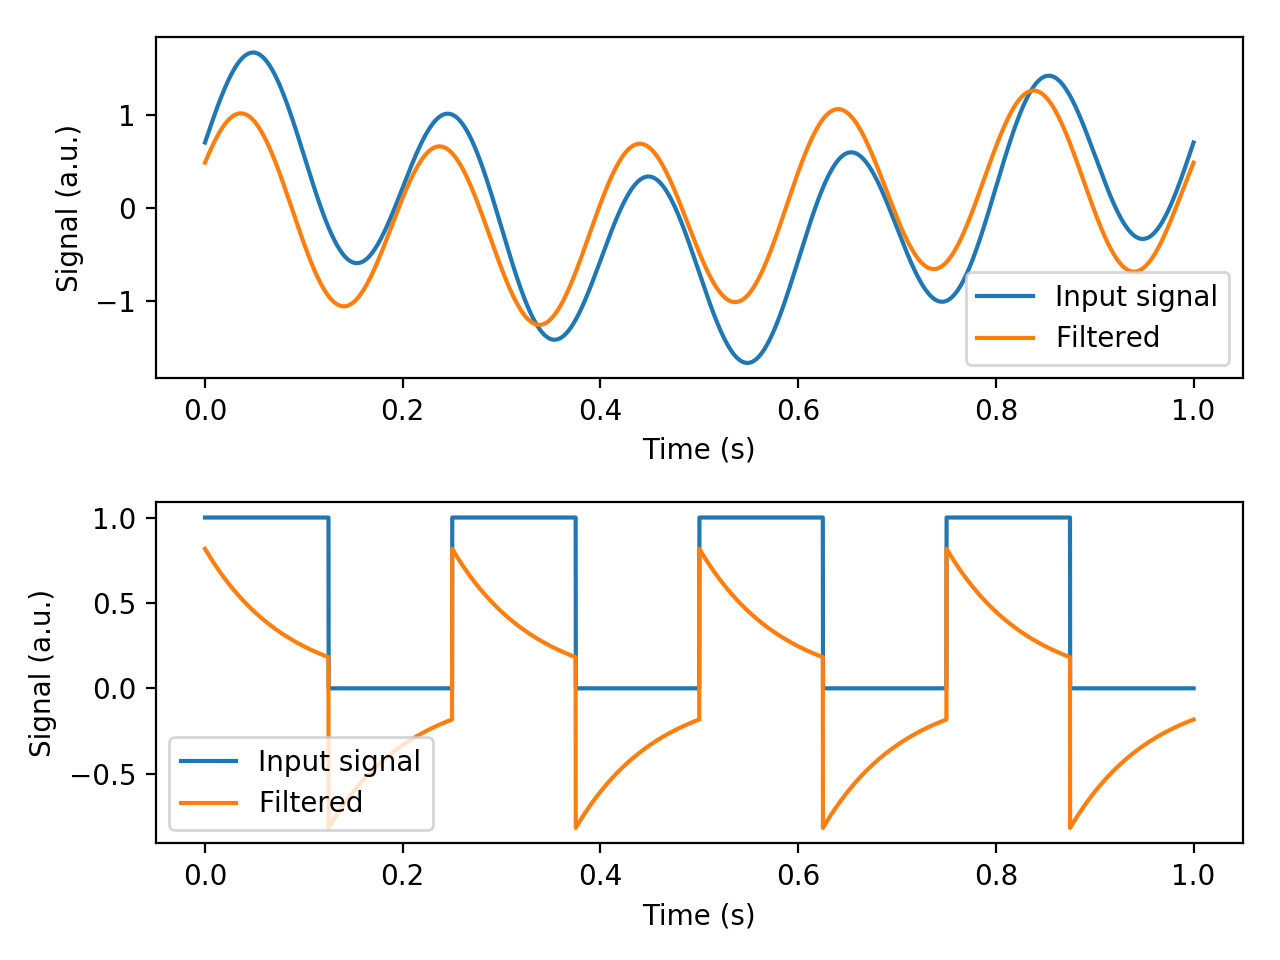

In [5]:
# And inspect the result

fig, axs = plt.subplots(2, 1)
axs[0].plot(time, signal1, label='Input signal')
axs[0].plot(time, signal1_filt, label='Filtered')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Signal (a.u.)')
axs[0].legend()

axs[1].plot(time, signal2, label='Input signal')
axs[1].plot(time, signal2_filt, label='Filtered')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Signal (a.u.)')
axs[1].legend()

plt.tight_layout()

In [6]:
# Similarly, we may pre-compensate for the filters

# Note that we specify a DC gain for the inverse filters. This is because it is not possible
# to compensate for the true DC gain of zero of an RC high pass. Instead, we specify the
# gain of the high-pass filter at DC. The compensated signal will have a mean value of 1/DCgain
# times the mean of the input signal


signal1_comp = applyInverseRCFilter(signal1, SR, filtertype, f_cut, order=1, DCgain=1)
signal2_comp = applyInverseRCFilter(signal2, SR, filtertype, f_cut, order=1, DCgain=1)

<IPython.core.display.Javascript object>


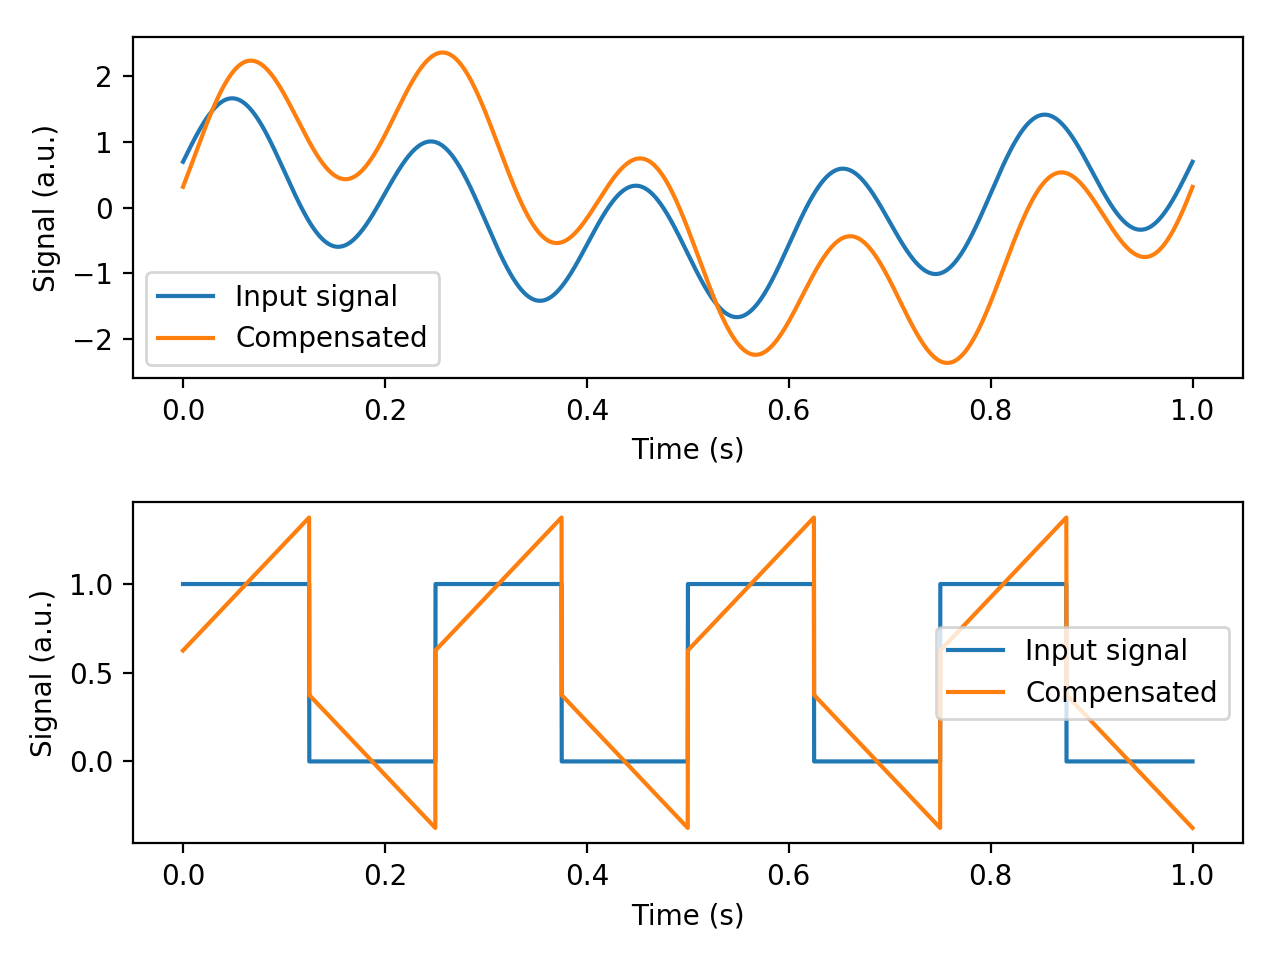

In [7]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(time, signal1, label='Input signal')
axs[0].plot(time, signal1_comp, label='Compensated')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Signal (a.u.)')
axs[0].legend()

axs[1].plot(time, signal2, label='Input signal')
axs[1].plot(time, signal2_comp, label='Compensated')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Signal (a.u.)')
axs[1].legend()

plt.tight_layout()

<IPython.core.display.Javascript object>


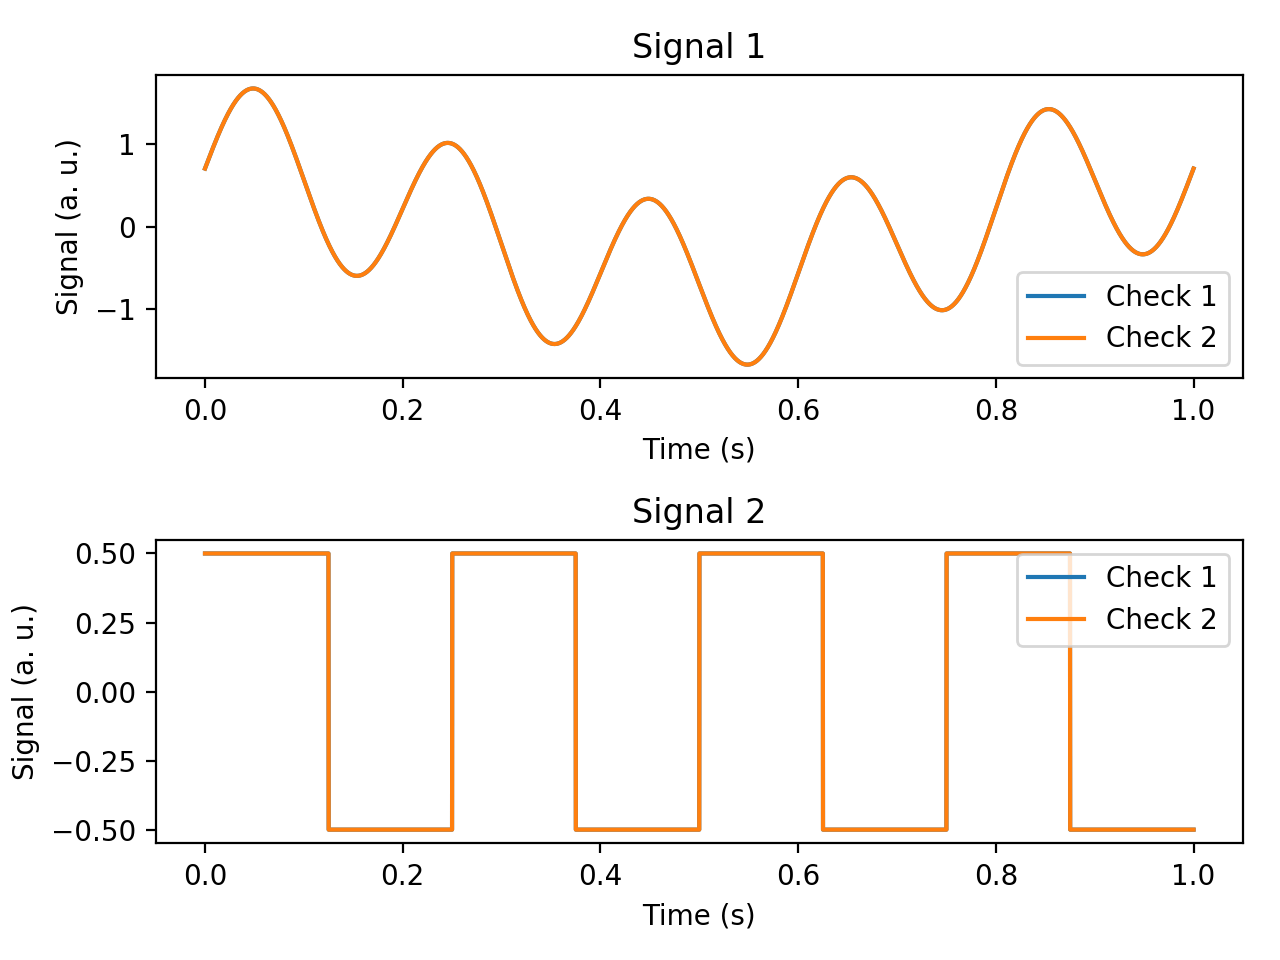

In [8]:
# As a sanity-check, we may filter and compensate and compare
#
# Do we recover the original signals?

signal1_check1 = applyRCFilter(signal1_comp, SR, filtertype, f_cut, order=1)
signal1_check2 = applyInverseRCFilter(signal1_filt, SR, filtertype, f_cut, order=1)

signal2_check1 = applyRCFilter(signal2_comp, SR, filtertype, f_cut, order=1)
signal2_check2 = applyInverseRCFilter(signal2_filt, SR, filtertype, f_cut, order=1)

fig, axs = plt.subplots(2, 1)
axs[0].set_title('Signal 1')
axs[0].plot(time, signal1_check1, label='Check 1')
axs[0].plot(time, signal1_check2, label='Check 2')
axs[0].legend()
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Signal (a. u.)')

axs[1].set_title('Signal 2')
axs[1].plot(time, signal2_check1, label='Check 1')
axs[1].plot(time, signal2_check2, label='Check 2')
axs[1].legend()
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Signal (a. u.)')

plt.tight_layout()

## User-supplied transfer function

In an experimental situation, it is sometimes best to simply _measure_ the transfer function of the transmission line and then apply (the inverse of) that transfer function to the system.

This is done with ripasso's `applyCustomTransferFunction`.

In the following example, we invite the user to experiment with `tf_noise_amp` to see the drastic effect of low filter function values. In a real experiment, some care should be taken to provide a very smooth transfer function, either by heavy averaging or by curve fitting to a sane model (or both).

<IPython.core.display.Javascript object>


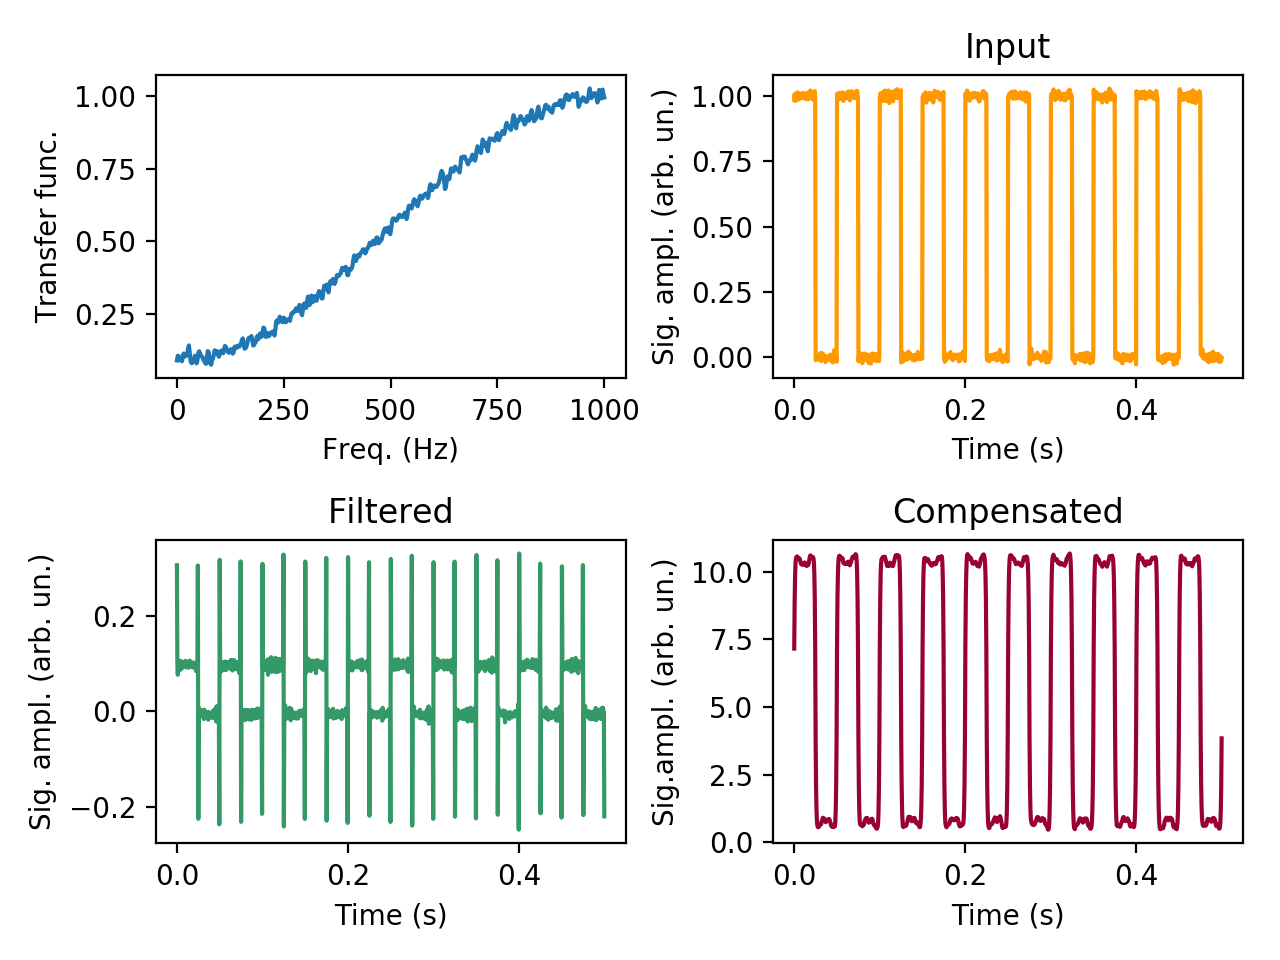

In [9]:
# Lets first make some semi-realistic transfer function

tf_points = 500

tf_freq = np.linspace(0, 1000, tf_points)
tf_amp = np.zeros(tf_points)
tf_amp += np.hanning(2*tf_points)[tf_points:][::-1]  # A high-pass 
tf_amp += 0.1  # Note: a transfer function with very low values give unphysical compensation
tf_amp /= tf_amp.max()

# and some experimental noise
tf_noise_amp = 0.02
tf_amp += np.convolve(0.02*np.random.randn(tf_points),
                      np.array([0.5, 1, 0.5]), mode='same')/2

# And then our favourite signal: the square wave

sig_points = 1000
signal = squarewave(sig_points, periods=10) + 0.01*np.random.randn(1000)
SR = 2000  # We pretend that the signal was sampled with this sample rate
time = np.linspace(0, sig_points/SR, sig_points)

# Then we may apply the filter we made

signal_filtered = applyCustomTransferFunction(signal, SR, tf_freq, tf_amp)

# Or conversely, we may apply its inverse

signal_compensated = applyCustomTransferFunction(signal, SR, tf_freq, tf_amp, invert=True)

# Finally, it's nice to visualise things

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(tf_freq, tf_amp)
axs[0, 0].set_xlabel('Freq. (Hz)')
axs[0, 0].set_ylabel('Transfer func.')

axs[0, 1].plot(time, signal, color='#ff9900')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Sig. ampl. (arb. un.)')
axs[0, 1].set_title('Input')

axs[1, 0].plot(time, signal_filtered, color='#339966')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Sig. ampl. (arb. un.)')
axs[1, 0].set_title('Filtered')

axs[1, 1].plot(time, signal_compensated, color='#990033')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Sig.ampl. (arb. un.)')
axs[1, 1].set_title('Compensated')

plt.tight_layout()